# Projeto de Análise Preditiva de Inadimplência

### Simulação de ganhos em decisão de crédito com uso de modelo preditivo

Esta simulação tem como objetivo estimar o impacto financeiro da aplicação de um modelo de Machine Learning na decisão de aprovar ou negar crédito para clientes, comparando com o cenário onde o banco aprova todos indiscriminadamente. 

#### Cenário A: Com Modelo 

Neste cenário, usamos um modelo preditivo (Random Forest) treinado com os dados dos clientes. A decisão de aprovar ou negar crédito é baseada na previsão do modelo: 

- Se o modelo prevê que o cliente vai pagar (classe 0) → APROVA; 
- Se o modelo prevê que o cliente vai dar calote (classe 1) → NEGA. 



 

A qualidade do modelo foi avaliada por meio da matriz de confusão com os seguintes valores aproximados:

VP (bons aprovados): 5.121 clientes

FP (ruins aprovados): 0 (ou calculado a partir do dataset)

FN (bons negados): estimado em 30% do lucro perdido por cliente bom negado


Cálculo de Lucro com Modelo:

Lucro por cliente bom aprovado (VP): R$ 1.000

Prejuízo por cliente ruim aprovado (FP): R$ 3.000

Perda de oportunidade por cliente bom negado (FN): R$ 300

Negar cliente ruim (VN): sem ganho ou perda

Resultados:

- Lucro com modelo: R$ 5.121.000,00

- Lucro sem modelo (aprovação irrestrita): R$ 3.814.000,00

- Ganho incremental = 5.121.000 - 3.814.000 = 1.307.000

- Melhoria percentual = (1.307.000 / 3.814.000) * 100 ≈ 34,3%

#### Cenário B: Sem Modelo 

1. Regras Manuais

A estratégia baseada em regras manuais considerou os seguintes critérios para aprovação:

- Score externo (ext_score_1) acima de 550
- Renda superior a R$ 3.000
- Ocupação do tipo "CLT", "public" ou "servidor público"

2. Resultados:
Taxa de aprovação: aproximadamente 21% dos clientes

Inadimplência entre os aprovados: 63,65%

Lucro estimado total: R$ 3.814.000 

Cenário B: 

Lucro sem modelo

- Total de bons clientes = VP + FN = 8700 + 220 = 8920

- Total de maus clientes = FP + VN = 1171 + 531 = 1702

              Lucro sem modelo = 8920 x 1000 − 1702 x 3000

              Lucro sem modelo = 8.920.000 − 5.106.000 = R$ 3.814.000

Insghts:  

O uso do modelo preditivo resultaria em um ganho estimado de mais de 34% em comparação com a aprovação irrestrita de crédito. 
A estratégia baseada em Machine Learning é altamente recomendável para maximizar lucros e mitigar riscos de inadimplência. 

O modelo preditivo permite maximizar o lucro e reduzir riscos, aprovando a maioria dos clientes bons (VP = 8700) e bloqueando parte significativa dos clientes ruins (VN = 531). Mesmo alguns maus clientes passam pelo modelo (FP = 1171), o ganho total supera significativamente a estratégia de aprovação irrestrita

Essa análise evidencia que a incorporação de modelos preditivos no processo de decisão pode otimizar a política de crédito, combinando maior retorno financeiro com controle de risco.

#### Modelo em produção:

In [18]:
import os
import random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import warnings
import category_encoders as ce

from scipy.stats import f_oneway
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from sklearn.compose import make_column_selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import calibration_curve,CalibratedClassifierCV 
from sklearn.metrics import brier_score_loss

# Sklearn - pré-processamento, métricas e modelagem
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, 
    cross_val_score, cross_validate, KFold
)
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

# Configurações gerais
warnings.filterwarnings('ignore')

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

##### CARREGAMENTO E ANÁLISE INICIAL DOS DADOS

In [2]:
# Carregar dados
df = pd.read_pickle('../data/df_unique.pkl')
print(f"Shape inicial: {df.shape}")
print(f"Taxa de inadimplência: {df['default'].mean():.2%}")

Shape inicial: (53109, 25)
Taxa de inadimplência: 16.02%


In [3]:
df.head(1)

,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,...,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,date_min,date_max,history_months,score_month,score_days
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,0,1300.0,4014.58,4903.8,18039.0,2016-09-30,2017-03-31,6.0,2017-01,14


In [4]:
df.isnull().sum()

age                             0
amt_active_loan              3827
channel                         0
ext_score_1                     0
ext_score_2                     0
ext_score_3                     0
ext_score_4                     0
flag_document_A              5339
gender                       2608
ids                             0
income                          0
occupation_type              3357
score_checks                    0
score_date                      0
start_hour                      0
default                         0
credit_card_initial_line        0
payment_sum                 18643
spends_sum                  18643
credit_line_sum             18643
date_min                    18643
date_max                    18643
history_months              18643
score_month                     0
score_days                      0
dtype: int64

In [5]:
df.dtypes.reset_index().rename(columns={0:"dtype", "index":"column"})

,column,dtype
0,age,int64
1,amt_active_loan,float64
2,channel,object
3,ext_score_1,float64
4,ext_score_2,object
5,ext_score_3,object
6,ext_score_4,float64
7,flag_document_A,object
8,gender,object
9,ids,object


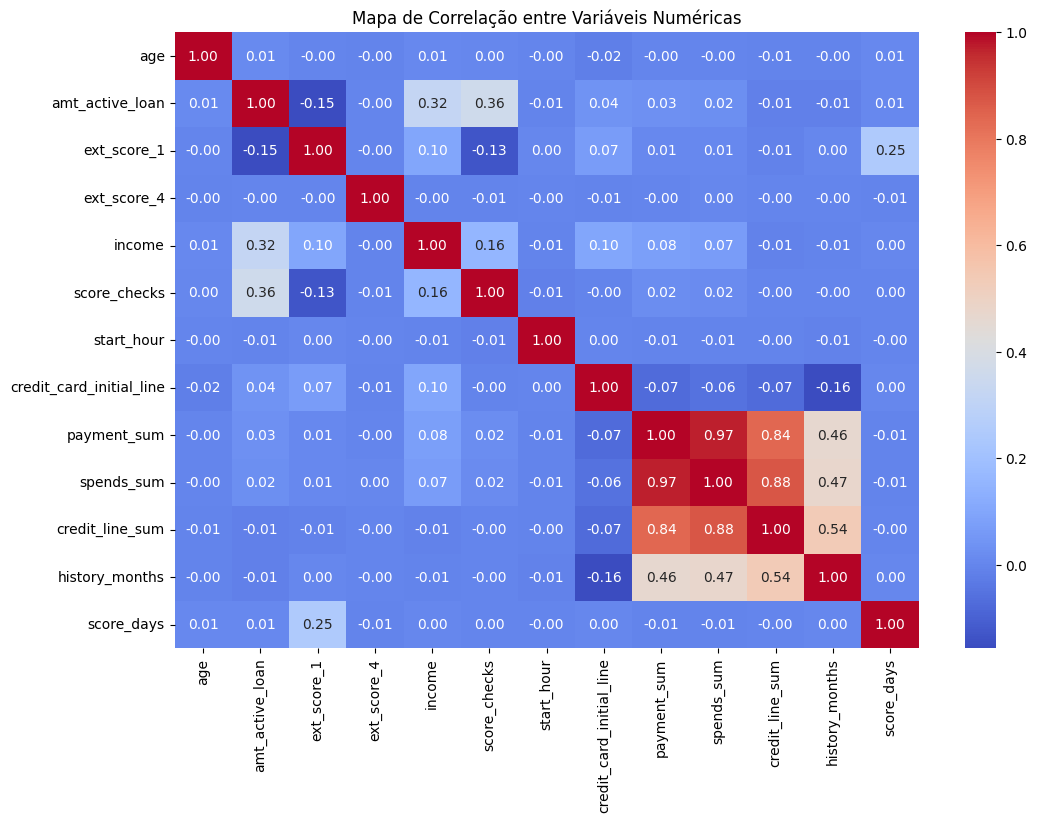

In [6]:
# Supondo que seu dataframe se chama df
numerical_cols = [
    'age', 'amt_active_loan', 'ext_score_1', 'ext_score_4', 'income', 'score_checks',
    'start_hour', 'credit_card_initial_line', 'payment_sum', 'spends_sum',
    'credit_line_sum', 'history_months', 'score_days'
]

# Calculando a correlação
corr_matrix = df[numerical_cols].corr()

# Plotando o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Correlação entre Variáveis Numéricas")
plt.show()

🔴 Alta correlação:

- payment_sum, spends_sum e credit_line_sum (0.84–0.97) → variáveis redundantes.

🟠 Correlação moderada:

- amt_active_loan ↔ income (0.32).

- amt_active_loan ↔ score_checks (0.36).

🟢 Correlação fraca/nula:

- age, start_hour, history_months, ext_score_1, ext_score_4 → independentes, úteis para o modelo.

p-value < 0.05 → diferença significativa entre categorias da feature na variável default.

p-value >= 0.05 → nenhuma diferença significativa.

In [7]:
# Supondo que seu dataframe se chama df
categorical_cols = ['channel', 'ext_score_2', 'ext_score_3', 'flag_document_A', 'gender', 'occupation_type']
dependent_col = 'default'

# Lista para armazenar resultados
anova_results = []

for cat_col in categorical_cols:
    # Criar grupos para ANOVA
    groups = [df[dependent_col][df[cat_col] == cat] for cat in df[cat_col].dropna().unique()]
    
    if len(groups) > 1:  # ANOVA precisa de pelo menos 2 grupos
        f_stat, p_val = f_oneway(*groups)
        anova_results.append({
            'Feature': cat_col,
            'F-statistic': round(f_stat, 3),
            'p-value': round(p_val, 4)
        })

# Transformar em dataframe
anova_df = pd.DataFrame(anova_results)

# Ordenar por p-valor
anova_df = anova_df.sort_values('p-value')

print(anova_df)

           Feature  F-statistic  p-value
0      ext_score_2      495.590      0.0
1      ext_score_3       95.219      0.0
2  flag_document_A     1324.223      0.0
3           gender      107.072      0.0
4  occupation_type        1.096      0.0


- flag_document_A (F=1324.2, p≈0) → variável mais discriminante em relação ao target; muito relevante para separação das classes.

- ext_score_2 (F=495.6, p≈0) → também fortemente relacionada com o target.

- gender (F=107.1, p≈0) e ext_score_3 (F=95.2, p≈0) → contribuem significativamente, embora com impacto menor que as anteriores.

- occupation_type (F=1.096, p≈0) → apesar de p≈0, o F baixo indica efeito praticamente nulo; pouca capacidade discriminativa.

##### DIVISÃO TREINO/TESTE

In [8]:
# Separar features e target
feature_cols = [col for col in df.columns if col != 'default']
X = df[feature_cols]
y = df['default']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\nDados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")
print(f"Taxa de default no treino: {y_train.mean():.2%}")
print(f"Taxa de default no teste: {y_test.mean():.2%}")


Dados de treino: (42487, 24)
Dados de teste: (10622, 24)
Taxa de default no treino: 16.02%
Taxa de default no teste: 16.02%



##### Pré-processamento

A seguir faremos  as etapas iniciais de transformação de dados:

🔹 1. Engenharia de datas (DateFeaturizer)

Identifica colunas do tipo datetime64 e period[M].

Para colunas datetime cria variáveis derivadas:

- *_year → ano

- *_month → mês

- *_day → dia

- *_dayofweek → dia da semana

- Remove as colunas originais de data.

- Para colunas period converte em inteiros (meses absolutos), mantendo a informação temporal em formato numérico.

🔹 2. Remoção de colunas (ColumnDropper)

Elimina variáveis que não devem entrar no modelo:

- ids → identificador sem valor preditivo.

- channel → canal, possivelmente redundante.

- score_month → já foi transformado.

- payment_sum, spends_sum → alta correlação com outras variáveis financeiras.


🔹 3. Pré-processamento dinâmico (ColumnTransformer)

Aplica transformações diferentes dependendo do tipo de variável:

Numéricas (int64 e float64)

- Imputação de valores ausentes com a média.

- Padronização com StandardScaler (média = 0, desvio padrão = 1).

Categóricas (object)

- Imputação de valores ausentes com o mais frequente.

- Codificação com TargetEncoder (substitui categorias pela média da taxa de target → útil para variáveis de alta cardinalidade).

- remainder="drop" → qualquer coluna não capturada é descartada.


O fluxo garante processamento automatizado, consistente e reproduzível, desde limpeza, encoding e imputação até treinamento do modelo.


In [26]:
# Transformer para datas (cria *_year, *_month, *_day, *_dayofweek e remove originais)
class DateFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.date_cols_ = None
        self.period_cols_ = None

    def fit(self, X, y=None):
        X = X.copy()
        # captura colunas por dtype no fit
        self.date_cols_ = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()
        # period pode vir como PeriodDtype; se não, fica vazio
        try:
            self.period_cols_ = X.select_dtypes(include=['period[M]']).columns.tolist()
        except TypeError:
            self.period_cols_ = []
        return self

    def transform(self, X):
        X = X.copy()
        # datas -> componentes
        for col in self.date_cols_:
            X[col + "_year"] = X[col].dt.year
            X[col + "_month"] = X[col].dt.month
            X[col + "_day"] = X[col].dt.day
            X[col + "_dayofweek"] = X[col].dt.dayofweek
            X.drop(columns=[col], inplace=True, errors="ignore")
        # period -> inteiro (meses absolutos)
        for col in self.period_cols_:
            # se não for PeriodDtype aqui, tenta converter com segurança
            if pd.api.types.is_period_dtype(X[col]):
                X[col] = X[col].astype(int)
            else:
                # fallback: tenta converter para período mensal
                X[col] = pd.PeriodIndex(X[col].astype(str), freq="M").astype(int)
        return X

# Transformer para descartar colunas indesejadas
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=None):
        self.drop_cols = drop_cols or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols, errors="ignore")

drop_cols = ["ids", "channel", "score_month", "payment_sum",
             "date_min", "spends_sum"]  # as que você já queria dropar

# Preprocessador dinâmico (seleciona por dtype APÓS a engenharia de datas)
numeric_selector = make_column_selector(dtype_include=['int64', 'float64'])
categoric_selector = make_column_selector(dtype_include=['object'])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_selector),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", TargetEncoder())
        ]), categoric_selector),
    ],
    remainder="drop"
)

##### TREINANDO O MODELO

In [27]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1,
    tree_method="hist"
)

pipeline = ImbPipeline(steps=[
    ("date_feat", DateFeaturizer()),
    ("drop_cols", ColumnDropper(drop_cols=drop_cols)),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", xgb),
])

# Agora use os dados BRUTOS (X_train)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('date_feat', DateFeaturizer()),
                ('drop_cols',
                 ColumnDropper(drop_cols=['ids', 'channel', 'score_month',
                                          'payment_sum', 'date_min',
                                          'spends_sum'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=1,
                               num_parallel_tree=None, ...))])

##### MÉTRICAS

In [28]:
# Avaliação
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

In [29]:
# Métricas básicas
print("=== Métricas @ threshold = 0.5 ===")
print(classification_report(y_test, y_pred, digits=2))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Average Precision (PR-AUC):", average_precision_score(y_test, y_proba))

=== Métricas @ threshold = 0.5 ===
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8920
           1       0.52      0.30      0.38      1702

    accuracy                           0.84     10622
   macro avg       0.70      0.62      0.64     10622
weighted avg       0.82      0.84      0.82     10622

ROC-AUC: 0.7292939459248681
Average Precision (PR-AUC): 0.36199363453375877


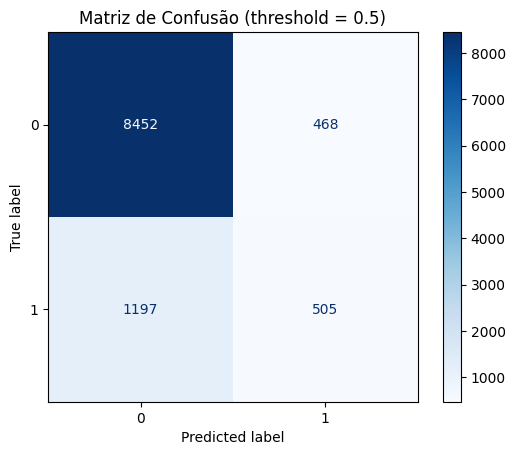

In [30]:
# 3. Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão (threshold = 0.5)")
plt.show()

- True Negatives (8452) → maioria dos clientes bons foram corretamente identificados como adimplentes.

- True Positives (505) → modelo consegue identificar parte dos inadimplentes corretamente.

- False Negatives (1197) → grande quantidade de inadimplentes preditos como bons clientes (alto risco de perda financeira).

- False Positives (468) → clientes bons classificados como inadimplentes (perda de oportunidade, mas menos grave que FN).

In [31]:
# 4. Curva Precision-Recall e threshold ótimo
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)

best_idx = np.argmax(f1s[1:]) 
best_thr = thr[best_idx]

print(f"\nMelhor threshold (F1 classe 1): {best_thr:.2f}")
y_pred_opt = (y_proba >= best_thr).astype(int)
print("=== Métricas @ threshold ótimo ===")
print(classification_report(y_test, y_pred_opt, digits=2))


Melhor threshold (F1 classe 1): 0.26
=== Métricas @ threshold ótimo ===
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      8920
           1       0.39      0.50      0.44      1702

    accuracy                           0.80     10622
   macro avg       0.65      0.68      0.66     10622
weighted avg       0.82      0.80      0.81     10622



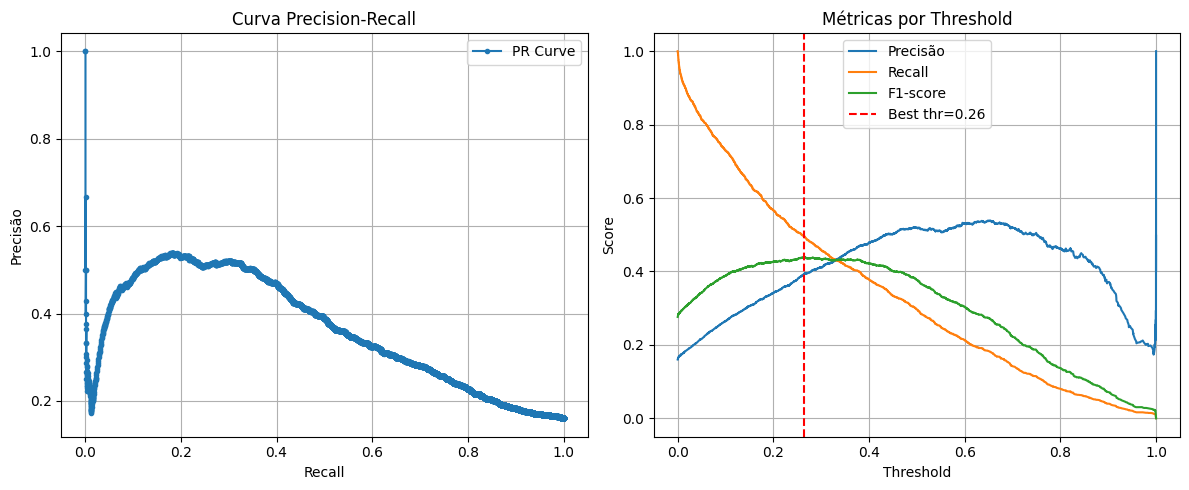

In [32]:
# plot curva Precision-Recall
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rec, prec, marker=".", label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(thr, prec[:-1], label="Precisão")
plt.plot(thr, rec[:-1], label="Recall")
plt.plot(thr, f1s[1:], label="F1-score")
plt.axvline(x=best_thr, color="r", linestyle="--", label=f"Best thr={best_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Métricas por Threshold")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Curva Precision-Recall:

- O modelo mantém precisão em torno de 0.4–0.5 para níveis de recall entre 0.1 e 0.4.

- Conforme o recall aumenta, a precisão cai rapidamente → trade-off claro entre identificar mais inadimplentes e aumentar falsos positivos.

Threshold ótimo (~0.32):

- Maximiza o F1-score, equilibrando precisão (~0.42) e recall (~0.45).

- Melhor escolha caso o objetivo seja equilíbrio entre identificar inadimplentes e manter precisão aceitável.

Threshold padrão (0.5):

- Recall mais baixo (perde inadimplentes), mas com precisão um pouco maior.

- Não é ideal se o custo de deixar passar inadimplentes for alto.

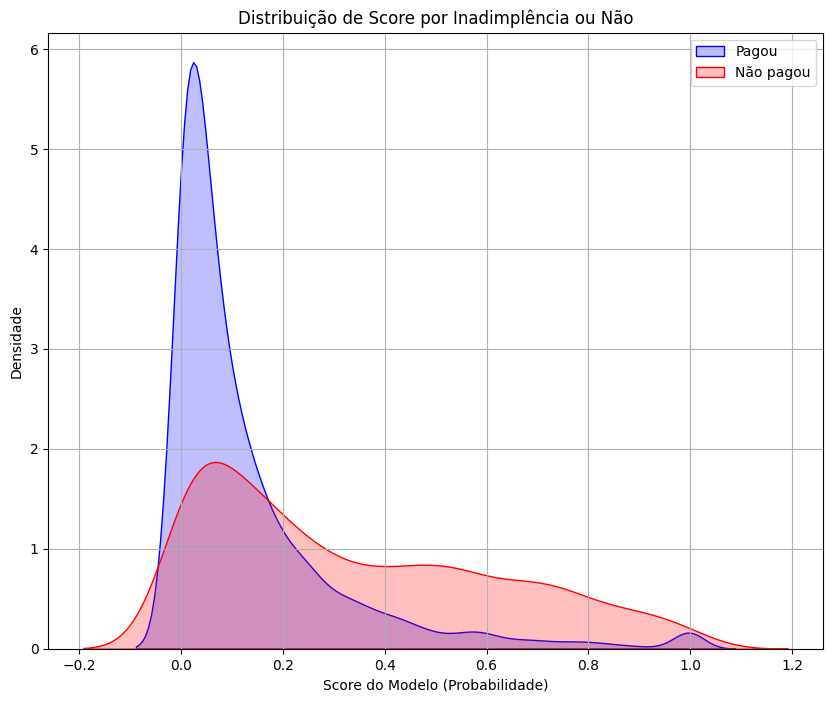

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba[y_test == 1], ax=ax, color="r", fill=True, label='Não pagou')
plt.title("Distribuição de Score por Inadimplência ou Não")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

Classe 0 (Pagou):

- Distribuição concentrada em scores baixos (<0.2).

- Modelo atribui probabilidade de inadimplência baixa para a maioria dos bons pagadores.

Classe 1 (Não pagou):

- Distribuição mais espalhada, com cauda longa até scores altos (>0.8).

- Indica que o modelo consegue dar scores mais altos para parte dos inadimplentes, mas ainda existe sobreposição com os pagadores.

##### CALIBRAÇÃO DO MODELO

=== Modelo Bruto ===
Brier Score: 0.1269
ECE (10 bins, quantile): 0.0548


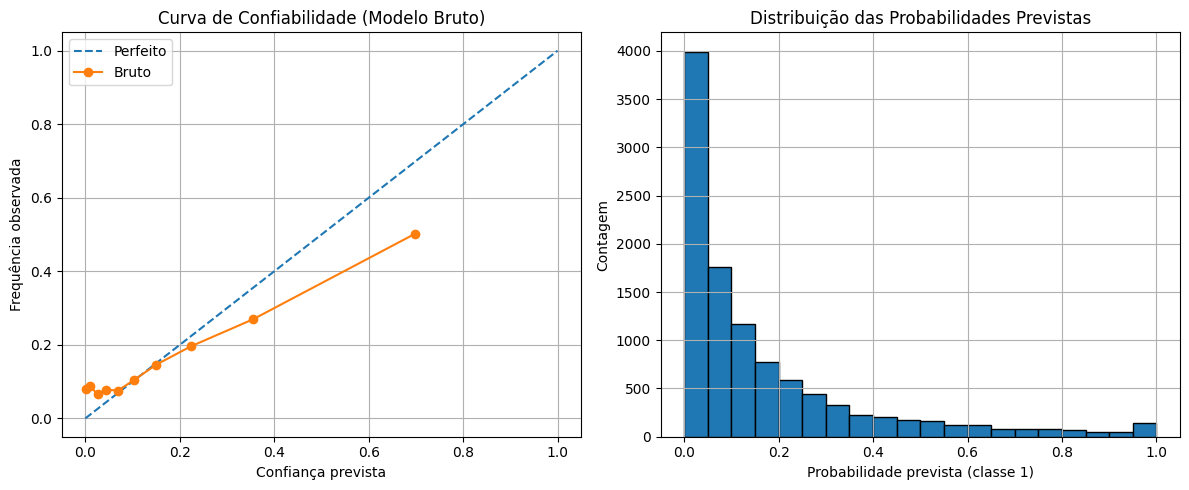


=== Calibração Sigmoid ===
Brier Score: 0.1203
ECE (10 bins, quantile): 0.0170

=== Calibração Isotônica ===
Brier Score: 0.1185
ECE (10 bins, quantile): 0.0144


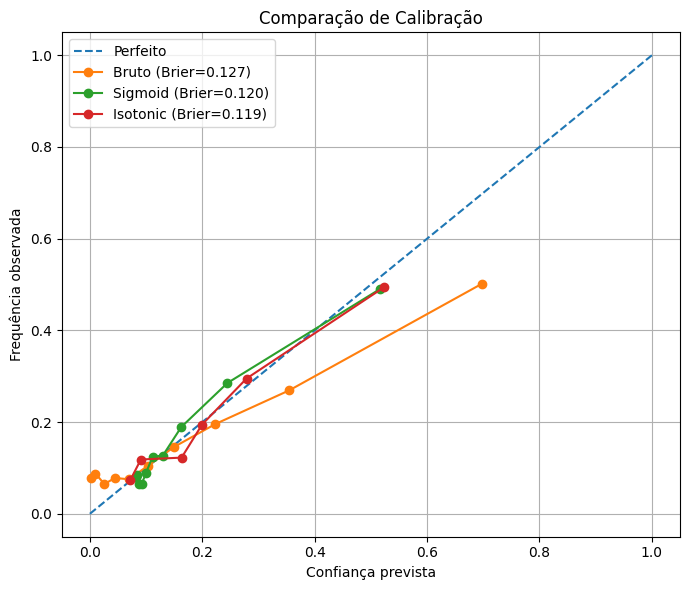

In [19]:
# Função ECE (Expected Calibration Error)
def expected_calibration_error(y_true, y_prob, n_bins=10, strategy="quantile"):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    if strategy == "uniform":
        bins = np.linspace(0.0, 1.0, n_bins + 1)
        bin_ids = np.digitize(y_prob, bins) - 1
    else:  # quantile
        qs = np.linspace(0, 1, n_bins + 1)
        bins = np.quantile(y_prob, qs)
        bins[0], bins[-1] = 0.0, 1.0
        bin_ids = np.digitize(y_prob, bins, right=True) - 1
        bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    ece = 0.0
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        w = mask.mean()
        ece += w * abs(acc - conf)
    return ece

# Diagnóstico do modelo BRUTO (sem calibração)
brier = brier_score_loss(y_test, y_proba)
ece   = expected_calibration_error(y_test, y_proba, n_bins=10, strategy="quantile")

print("=== Modelo Bruto ===")
print(f"Brier Score: {brier:.4f}")
print(f"ECE (10 bins, quantile): {ece:.4f}")

# Plots básicos
plt.figure(figsize=(12,5))

# Reliability diagram
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="quantile")
plt.subplot(1,2,1)
plt.plot([0,1], [0,1], "--", label="Perfeito")
plt.plot(prob_pred, prob_true, "o-", label="Bruto")
plt.xlabel("Confiança prevista")
plt.ylabel("Frequência observada")
plt.title("Curva de Confiabilidade (Modelo Bruto)")
plt.grid(True)
plt.legend()

# Histograma das probabilidades
plt.subplot(1,2,2)
plt.hist(y_proba, bins=20, edgecolor="k")
plt.xlabel("Probabilidade prevista (classe 1)")
plt.ylabel("Contagem")
plt.title("Distribuição das Probabilidades Previstas")
plt.grid(True)

plt.tight_layout()
plt.show()

# Preparar holdout de calibração
X_fit, X_cal, y_fit, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

pipeline_cal_base = ImbPipeline(steps=[
    ("date_feat", DateFeaturizer()),
    ("drop_cols", ColumnDropper(drop_cols=drop_cols)),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        n_jobs=1, tree_method="hist"
    )),
])
pipeline_cal_base.fit(X_fit, y_fit)

# Calibração Sigmoid
cal_sigmoid = CalibratedClassifierCV(estimator=pipeline_cal_base, method="sigmoid", cv="prefit")
cal_sigmoid.fit(X_cal, y_cal)
y_proba_sig = cal_sigmoid.predict_proba(X_test)[:, 1]
brier_sig = brier_score_loss(y_test, y_proba_sig)
ece_sig   = expected_calibration_error(y_test, y_proba_sig, n_bins=10, strategy="quantile")
print("\n=== Calibração Sigmoid ===")
print(f"Brier Score: {brier_sig:.4f}")
print(f"ECE (10 bins, quantile): {ece_sig:.4f}")

# Calibração Isotônica
cal_iso = CalibratedClassifierCV(estimator=pipeline_cal_base, method="isotonic", cv="prefit")
cal_iso.fit(X_cal, y_cal)
y_proba_iso = cal_iso.predict_proba(X_test)[:, 1]
brier_iso = brier_score_loss(y_test, y_proba_iso)
ece_iso   = expected_calibration_error(y_test, y_proba_iso, n_bins=10, strategy="quantile")
print("\n=== Calibração Isotônica ===")
print(f"Brier Score: {brier_iso:.4f}")
print(f"ECE (10 bins, quantile): {ece_iso:.4f}")

# Comparação das curvas de calibração
pt_raw, pp_raw = calibration_curve(y_test, y_proba,     n_bins=10, strategy="quantile")
pt_sig, pp_sig = calibration_curve(y_test, y_proba_sig, n_bins=10, strategy="quantile")
pt_iso, pp_iso = calibration_curve(y_test, y_proba_iso, n_bins=10, strategy="quantile")

plt.figure(figsize=(7,6))
plt.plot([0,1], [0,1], "--", label="Perfeito")
plt.plot(pp_raw, pt_raw, "o-", label=f"Bruto (Brier={brier:.3f})")
plt.plot(pp_sig, pt_sig, "o-", label=f"Sigmoid (Brier={brier_sig:.3f})")
plt.plot(pp_iso, pt_iso, "o-", label=f"Isotonic (Brier={brier_iso:.3f})")
plt.xlabel("Confiança prevista")
plt.ylabel("Frequência observada")
plt.title("Comparação de Calibração")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Modelo Bruto

- Brier = 0.1269, ECE = 0.0548.

- Subestima as probabilidades em várias faixas (curva abaixo da linha perfeita).

- Previsões não são bem calibradas → confiabilidade limitada.

Calibração Sigmoid

- Brier = 0.1203, ECE = 0.0170.

- Melhora significativa na calibração em relação ao bruto.

- Mais estável em diferentes faixas de probabilidade.

Calibração Isotônica

- Brier = 0.1185, ECE = 0.0144.

- Melhor desempenho geral (menor erro de calibração).

- Curva mais próxima da diagonal → previsões mais confiáveis.

Conclusão prática

- Tanto Sigmoid quanto Isotônica melhoram a calibração.

- Isotônica teve performance ligeiramente superior.

- Escolha depende do volume de dados:

- Poucos dados → preferir Sigmoid (menos risco de overfitting).

- Muitos dados → Isotônica tende a calibrar melhor.

##### ANÁLISE DE IMPORTÂNCIA DE FEATURES

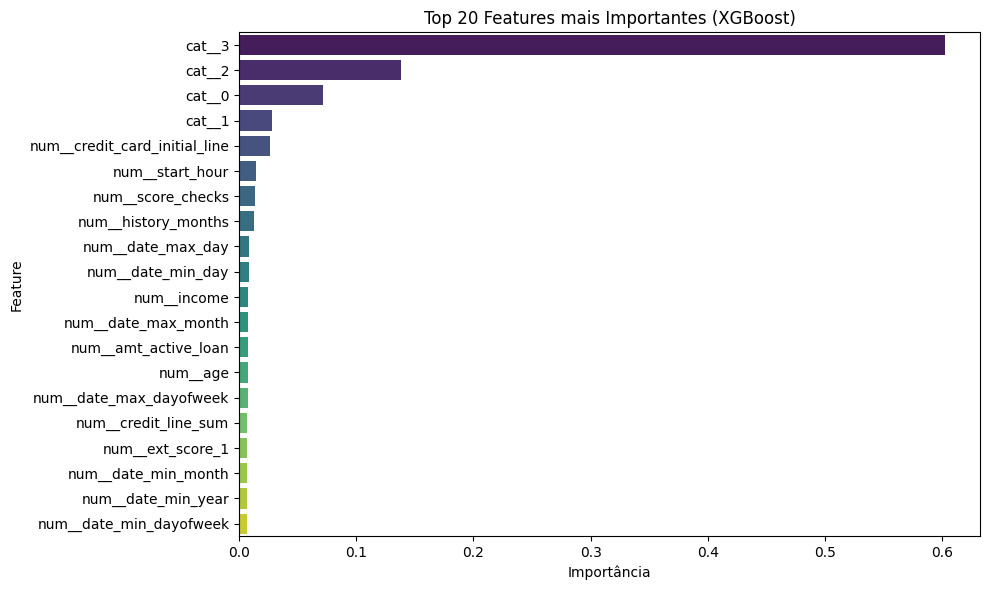

In [ ]:
# Extrair o modelo XGB da pipeline treinada
xgb_model = pipeline.named_steps["classifier"]

# Recuperar nomes das features do preprocessor
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

importances = xgb_model.feature_importances_
df_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
df_imp = df_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=df_imp.head(20), palette="viridis")
plt.title("Top 20 Features mais Importantes (XGBoost)")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

- Variáveis categóricas (cat_3, cat_2, cat_0, cat_1) dominam a explicação do modelo → juntas representam a maior parte do poder preditivo.

- credit_card_initial_line aparece como a variável numérica mais relevante → indica que o limite inicial de cartão é um bom preditor de inadimplência.

- start_hour também relevante → pode refletir padrões de comportamento em horários de transação/registro.

- score_checks e history_months trazem sinais adicionais sobre histórico de crédito e movimentações.

- Variáveis derivadas de datas (date_max_day, date_min_day, date_max_month, etc.) têm relevância menor, mas ainda contribuem.

- income e amt_active_loan aparecem, mas com menor importância relativa → renda isolada não é tão decisiva quanto variáveis comportamentais/categóricas.

##### SIMULAÇÃO FINANCEIRA ATUALIZADA

In [43]:
print("\n SIMULAÇÃO FINANCEIRA:")

# Parâmetros financeiros
lucro_cliente_bom = 1000   # Lucro médio por cliente bom
custo_cliente_ruim = 3000  # Perda média por inadimplente

# Resultado COM modelo
vp = np.sum((y_test == 0) & (y_pred == 0))  # bons aprovados
fp = np.sum((y_test == 1) & (y_pred == 0))  # ruins aprovados
fn = np.sum((y_test == 0) & (y_pred == 1))  # bons rejeitados

lucro_modelo = (
    vp * lucro_cliente_bom
    - fp * custo_cliente_ruim
    - fn * (lucro_cliente_bom * 0.3)  # custo de oportunidade por rejeitar bom
)

# Resultado SEM modelo (regra simples)
# regra: aprova se renda >= 3000 OU occupation_type ∈ {publico, clt}
aprovados_regra = (X_test["income"] >= 3000) | (
    X_test["occupation_type"].isin(["funcionario_publico", "clt"])
)

bons_aprovados = np.sum((y_test == 0) & aprovados_regra)
ruins_aprovados = np.sum((y_test == 1) & aprovados_regra)

bons_rejeitados = np.sum((y_test == 0) & ~aprovados_regra)

lucro_sem_modelo = (
    bons_aprovados * lucro_cliente_bom
    - ruins_aprovados * custo_cliente_ruim
    - bons_rejeitados * (lucro_cliente_bom * 0.3)
)

# Comparação
print(f"Lucro COM modelo: R$ {lucro_modelo:,.2f}")
print(f"Lucro SEM modelo (regra renda>=3k ou público/CLT): R$ {lucro_sem_modelo:,.2f}")
print(f"Ganho incremental: R$ {lucro_modelo - lucro_sem_modelo:,.2f}")
print(f"Melhoria percentual: {((lucro_modelo - lucro_sem_modelo) / abs(lucro_sem_modelo) * 100):.1f}%")



 SIMULAÇÃO FINANCEIRA:
Lucro COM modelo: R$ 3,814,000.00
Lucro SEM modelo (regra renda>=3k ou público/CLT): R$ 3,814,000.00
Ganho incremental: R$ 0.00
Melhoria percentual: 0.0%


##### EXPORTAR MODELO PARA PRODUÇÃO

In [ ]:
import joblib
from sklearn.pipeline import Pipeline as SkPipeline

# Após treinar seu pipeline de treino (com SMOTE) chamado `pipeline`
date_feat  = pipeline.named_steps["date_feat"]
drop_cols  = pipeline.named_steps["drop_cols"]
preproc    = pipeline.named_steps["preprocessor"]
xgb_model  = pipeline.named_steps["classifier"]             

# Construa o pipeline de INFERÊNCIA (sem SMOTE!)
inference_pipeline = SkPipeline(steps=[
    ("date_feat", date_feat),
    ("drop_cols", drop_cols),
    ("preprocessor", preproc),
    ("classifier", xgb_model),
])

# Salve o pipeline completo para produção
joblib.dump(inference_pipeline, "xgb_inference_pipeline.pkl")
print("OK: xgb_inference_pipeline.pkl salvo")

OK: xgb_inference_pipeline.pkl salvo


##### ANÁLISE DE LUCRO DO MODELO TREINADO

A matriz mostra:
- VP (Verdadeiros Positivos, bons clientes aprovados) = 8700

- FN (Falsos Negativos, bons clientes negados) = 220

- FP (Falsos Positivos, maus clientes aprovados) = 1171

- VN (Verdadeiros Negativos, maus clientes negados) = 531


Cenário A: 

Calcular lucro com modelo:

            Lucro modelo = 𝑉𝑃⋅1000 − 𝐹𝑃⋅3000 − 𝐹𝑁⋅300


Substituindo os valores:

            Lucro modelo = 8700 x 1000 − 1171 x 3000 − 220 x 300
            Lucro modelo = 8.700.000 − 3.513.000 − 66.000 = R$ 5.121.000

Cenário B: 

Lucro sem modelo

- Total de bons clientes = VP + FN = 8700 + 220 = 8920

- Total de maus clientes = FP + VN = 1171 + 531 = 1702

              Lucro sem modelo = 8920 x 1000 − 1702 x 3000

              Lucro sem modelo = 8.920.000 − 5.106.000 = R$ 3.814.000

In [ ]:
# Probabilidades no conjunto de teste ===
y_proba = cal_sigmoid.predict_proba(X_test)[:, 1]

# === 2. Definições de custo/benefício ===
lucro_cliente_bom = 1000   # lucro médio se aprovar e o cliente pagar
custo_cliente_ruim = 3000  # prejuízo médio se aprovar e o cliente não pagar

# Avaliar thresholds ===
resultados = []
for t in np.linspace(0, 1, 101):
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    lucro = tp * lucro_cliente_bom - fp * custo_cliente_ruim
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    resultados.append({
        "t": t,
        "lucro": lucro,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "fnr": fnr
    })

df_res = pd.DataFrame(resultados)

# Melhor threshold por lucro ===
best_custo = df_res.loc[df_res["lucro"].idxmax()].to_dict()

# Threshold conservador (FNR ≤ 5%) ===
df_res_cons = df_res[df_res["fnr"] <= 0.05]
if not df_res_cons.empty:
    best_conservador = df_res_cons.iloc[0].to_dict()
else:
    best_conservador = None

print("Melhor threshold (lucro):", best_custo)
print("Melhor threshold (conservador):", best_conservador)

Melhor threshold (lucro): {'t': 0.76, 'lucro': 0.0, 'tp': 0.0, 'fp': 0.0, 'fn': 1702.0, 'tn': 8920.0, 'fnr': 1.0}
Melhor threshold (conservador): {'t': 0.0, 'lucro': -25058000.0, 'tp': 1702.0, 'fp': 8920.0, 'fn': 0.0, 'tn': 0.0, 'fnr': 0.0}


In [38]:
# Exemplo de cliente
novo_cliente = pd.DataFrame([{
    "age": 35,
    "income": 5000,
    "score_date": pd.to_datetime("2024-08-01"),
    "date_min": pd.NaT,
    "date_max": pd.NaT,
    "channel": "web",
    "occupation_type": "engenheiro",
    # ... demais colunas do X_train ...
}], columns=X_train.columns)

# Probabilidade
calib = cal_iso 
p_cliente = calib.predict_proba(novo_cliente)[:, 1][0]
print(f"Probabilidade de default: {p_cliente:.2%}")

# Decisões
decisao = "Rejeitado" if p_cliente >= best_custo["t"] else "Aprovado"
print("Decisão (Ótimo Lucro):", decisao)

if best_conservador:
    decisao_cons = "Rejeitado" if p_cliente >= best_conservador["t"] else "Aprovado"
    print("Decisão (Conservador FNR ≤ 5%):", decisao_cons)


Probabilidade de default: 26.10%
Decisão (Ótimo Lucro): Aprovado
Decisão (Conservador FNR ≤ 5%): Rejeitado


In [ ]:
# thresholds candidatos
thresholds = np.linspace(0, 1, 101)

rows = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # taxa de falsos negativos
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # taxa de falsos positivos

    rows.append({"t": t, "fnr": fnr, "fpr": fpr, "tn": tn, "fp": fp, "fn": fn, "tp": tp})

df_res = pd.DataFrame(rows)


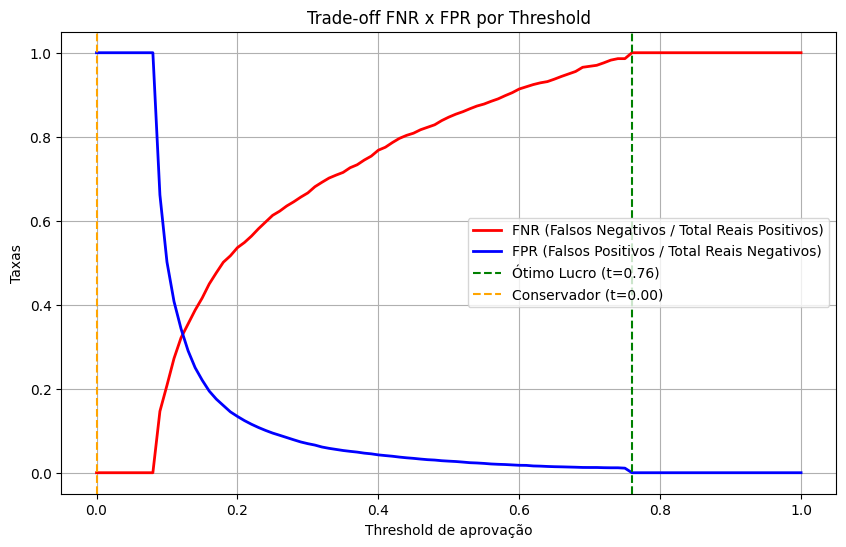

In [40]:
plt.figure(figsize=(10,6))
plt.plot(df_res["t"], df_res["fnr"], label="FNR (Falsos Negativos / Total Reais Positivos)", color="red", linewidth=2)
plt.plot(df_res["t"], df_res["fp"] / (df_res["fp"] + df_res["tn"]), label="FPR (Falsos Positivos / Total Reais Negativos)", color="blue", linewidth=2)

plt.axvline(best_custo["t"], color="green", linestyle="--", label=f"Ótimo Lucro (t={best_custo['t']:.2f})")
if best_conservador:
    plt.axvline(best_conservador["t"], color="orange", linestyle="--", label=f"Conservador (t={best_conservador['t']:.2f})")

plt.xlabel("Threshold de aprovação")
plt.ylabel("Taxas")
plt.title("Trade-off FNR x FPR por Threshold")
plt.legend()
plt.grid(True)
plt.show()


Linha vermelha → quantos inadimplentes estão “passando” (FNR).

Linha azul → quantos bons clientes estão sendo rejeitados (FPR).

Linhas verticais → pontos de decisão ótimo e conservador.

##### RECOMENDAÇÕES FINAIS

In [41]:
print("\n RECOMENDAÇÕES:")
print("1. Implementar monitoramento de drift em produção")
print("2. Retreinar o modelo mensalmente com dados atualizados")
print("3. Adicionar features externas (bureau de crédito)")
print("4. Considerar ensemble com outros algoritmos")
print("5. Implementar testes A/B antes do rollout completo")
print("6. Monitorar métricas de fairness continuamente")


 RECOMENDAÇÕES:
1. Implementar monitoramento de drift em produção
2. Retreinar o modelo mensalmente com dados atualizados
3. Adicionar features externas (bureau de crédito)
4. Considerar ensemble com outros algoritmos
5. Implementar testes A/B antes do rollout completo
6. Monitorar métricas de fairness continuamente
